In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import glob 
import time 
import h5py
import cv2
import torchinfo 
import torch
import torch.nn as nn
import argparse
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
from hsi_dataset import TrainDataset, ValidDataset
from architecture import *
from utils import *

import datetime
import wandb
import time 

/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
'test'

In [2]:
models = ['hscnn_plus', 'restormer','mst_plus_plus' ,'vitmstpp', 'vitmstpp_pad']

In [3]:
models_dict = {}
inputs = [128, 256, 384, 512, 768, 1024]
macs_dict = {}
for md in models:
    print(' ')
    print(' ') 
    print(md)
    model = model_generator(md).cuda()
    macs_dict[md] = []
    for i in inputs: 
        torch.cuda.empty_cache()
        nm = md +'_' + str(i)
        print(nm)
        models_dict[nm] = {}
        print('TORCHINFO')
        try: 
            summary_str = str(torchinfo.summary(model, input_size=(2,3,i,i)))
            models_dict[nm]['MACs'] = summary_str.split('Total mult-adds ')[1].split('\n')[0]
            models_dict[nm]['tot_size'] = summary_str.split('Estimated Total Size ')[1].split('\n')[0]
            models_dict[nm]['trainable'] = int(summary_str.split('Trainable params: ')[1].split('\n')[0].replace(',',''))
        except: 
            del model 
            torch.cuda.empty_cache()
            print('NOT ABLE TO SCALE TO 1024')
            print(nm)

        if i <= 256: 
            n_params, gmac = my_summary(model, i, i, 3, 2)
            models_dict[nm]['n_params'] = int(n_params)
            models_dict[nm]['gmac'] = float(gmac)

        if 'T' in models_dict[nm]['MACs']: 
            macs = float(models_dict[nm]['MACs'].split(': ')[1])*1000
            macs_dict[md].append(macs)
        elif 'G' in models_dict[nm]['MACs']: 
            macs = float(models_dict[nm]['MACs'].split(': ')[1])
            macs_dict[md].append(macs)
        else:
            print('error')
        
    del model

 
 
hscnn_plus
hscnn_plus_128
TORCHINFO
HSCNN_Plus(
  (ddfn): ddfn(
    (conv_up1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_up2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv_down1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_down2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (dfus_blocks): Sequential(
      (0): dfus_block(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_up1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_up2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_down1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_down2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_fution): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)


Unsupported operator aten::rsub encountered 2 time(s)
Unsupported operator aten::reflection_pad2d encountered 1 time(s)
Unsupported operator aten::mul encountered 532 time(s)
Unsupported operator aten::mul_ encountered 115 time(s)
Unsupported operator aten::mean encountered 46 time(s)
Unsupported operator aten::var encountered 46 time(s)
Unsupported operator aten::sub encountered 46 time(s)
Unsupported operator aten::add encountered 139 time(s)
Unsupported operator aten::sqrt encountered 46 time(s)
Unsupported operator aten::div encountered 92 time(s)
Unsupported operator aten::norm encountered 46 time(s)
Unsupported operator aten::clamp_min encountered 46 time(s)
Unsupported operator aten::expand_as encountered 46 time(s)
Unsupported operator aten::softmax encountered 23 time(s)
Unsupported operator aten::gelu encountered 23 time(s)
Unsupported operator aten::pixel_shuffle encountered 3 time(s)


GMac:43.666202545166016
Params:15108705
restormer_256
TORCHINFO
Restormer(
  (patch_embed): OverlapPatchEmbed(
    (proj): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (encoder_level1): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm(
        (body): WithBias_LayerNorm()
      )
      (attn): Attention(
        (qkv): Conv2d(48, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (qkv_dwconv): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (project_out): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm2): LayerNorm(
        (body): WithBias_LayerNorm()
      )
      (ffn): FeedForward(
        (project_in): Conv2d(48, 254, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (dwconv): Conv2d(254, 254, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=254, bias=False)
        (project_out): Conv2d(127, 48, kernel_size=(1, 1), strid

Unsupported operator aten::rsub encountered 2 time(s)
Unsupported operator aten::reflection_pad2d encountered 1 time(s)
Unsupported operator aten::mul encountered 532 time(s)
Unsupported operator aten::mul_ encountered 115 time(s)
Unsupported operator aten::mean encountered 46 time(s)
Unsupported operator aten::var encountered 46 time(s)
Unsupported operator aten::sub encountered 46 time(s)
Unsupported operator aten::add encountered 139 time(s)
Unsupported operator aten::sqrt encountered 46 time(s)
Unsupported operator aten::div encountered 92 time(s)
Unsupported operator aten::norm encountered 46 time(s)
Unsupported operator aten::clamp_min encountered 46 time(s)
Unsupported operator aten::expand_as encountered 46 time(s)
Unsupported operator aten::softmax encountered 23 time(s)
Unsupported operator aten::gelu encountered 23 time(s)
Unsupported operator aten::pixel_shuffle encountered 3 time(s)


GMac:174.66481018066406
Params:15108705
restormer_384
TORCHINFO
restormer_512
TORCHINFO
restormer_768
TORCHINFO
restormer_1024
TORCHINFO
 
 
mst_plus_plus
mst_plus_plus_128
TORCHINFO
MST_Plus_Plus(
  (conv_in): Conv2d(3, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (body): Sequential(
    (0): MST(
      (embedding): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (encoder_layers): ModuleList(
        (0): ModuleList(
          (0): MSAB(
            (blocks): ModuleList(
              (0): ModuleList(
                (0): MS_MSA(
                  (to_q): Linear(in_features=31, out_features=31, bias=False)
                  (to_k): Linear(in_features=31, out_features=31, bias=False)
                  (to_v): Linear(in_features=31, out_features=31, bias=False)
                  (proj): Linear(in_features=31, out_features=31, bias=True)
                  (pos_emb): Sequential(
                    (0): Conv2d(31, 31, kernel_size

Unsupported operator aten::rsub encountered 2 time(s)
Unsupported operator aten::reflection_pad2d encountered 1 time(s)
Unsupported operator aten::mul encountered 45 time(s)
Unsupported operator aten::norm encountered 30 time(s)
Unsupported operator aten::clamp_min encountered 30 time(s)
Unsupported operator aten::expand_as encountered 30 time(s)
Unsupported operator aten::div encountered 30 time(s)
Unsupported operator aten::softmax encountered 15 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::gelu encountered 45 time(s)
Unsupported operator aten::add encountered 48 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
body.0.lrelu, body.1.lrelu, body.2.lrelu


GMac:10.379768371582031
Params:1619625
mst_plus_plus_256
TORCHINFO
MST_Plus_Plus(
  (conv_in): Conv2d(3, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (body): Sequential(
    (0): MST(
      (embedding): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (encoder_layers): ModuleList(
        (0): ModuleList(
          (0): MSAB(
            (blocks): ModuleList(
              (0): ModuleList(
                (0): MS_MSA(
                  (to_q): Linear(in_features=31, out_features=31, bias=False)
                  (to_k): Linear(in_features=31, out_features=31, bias=False)
                  (to_v): Linear(in_features=31, out_features=31, bias=False)
                  (proj): Linear(in_features=31, out_features=31, bias=True)
                  (pos_emb): Sequential(
                    (0): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=31, bias=False)
                    (1): GELU()
                    (

Unsupported operator aten::rsub encountered 2 time(s)
Unsupported operator aten::reflection_pad2d encountered 1 time(s)
Unsupported operator aten::mul encountered 45 time(s)
Unsupported operator aten::norm encountered 30 time(s)
Unsupported operator aten::clamp_min encountered 30 time(s)
Unsupported operator aten::expand_as encountered 30 time(s)
Unsupported operator aten::div encountered 30 time(s)
Unsupported operator aten::softmax encountered 15 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::gelu encountered 45 time(s)
Unsupported operator aten::add encountered 48 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
body.0.lrelu, body.1.lrelu, body.2.lrelu


GMac:41.519073486328125
Params:1619625
mst_plus_plus_384
TORCHINFO
mst_plus_plus_512
TORCHINFO
mst_plus_plus_768
TORCHINFO
mst_plus_plus_1024
TORCHINFO
 
 
vitmstpp
Initialized VITMSTPPUNet with MSTPP stages: 6 and normalization instance
vitmstpp_128
TORCHINFO


/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


VITMSTPP(
  (vit): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU()
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2)

/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Unsupported operator aten::add encountered 192 time(s)
Unsupported operator aten::rsub encountered 18 time(s)
Unsupported operator aten::add_ encountered 79 time(s)
Unsupported operator aten::mul encountered 244 time(s)
Unsupported operator aten::div encountered 134 time(s)
Unsupported operator aten::sub encountered 52 time(s)
Unsupported operator aten::softmax encountered 42 time(s)
Unsupported operator aten::gelu encountered 102 time(s)


GMac:910.0643557310104
Params:92991682
vitmstpp_256
TORCHINFO


/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


VITMSTPP(
  (vit): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU()
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2)

/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Unsupported operator aten::add encountered 192 time(s)
Unsupported operator aten::rsub encountered 18 time(s)
Unsupported operator aten::add_ encountered 79 time(s)
Unsupported operator aten::mul encountered 244 time(s)
Unsupported operator aten::div encountered 134 time(s)
Unsupported operator aten::sub encountered 52 time(s)
Unsupported operator aten::softmax encountered 42 time(s)
Unsupported operator aten::gelu encountered 102 time(s)


GMac:922.1787194013596
Params:92991682
vitmstpp_384
TORCHINFO
vitmstpp_512
TORCHINFO
vitmstpp_768
TORCHINFO
vitmstpp_1024
TORCHINFO
 
 
vitmstpp_pad
Initialized VITMSTPPUNet with MSTPP stages: 6 and normalization instance
vitmstpp_pad_128
TORCHINFO
VITMSTPP_Pad(
  (vit): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU()
        )
      )
      (1): Block(
        (nor

/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Unsupported operator aten::rsub encountered 26 time(s)
Unsupported operator aten::reflection_pad2d encountered 3 time(s)
Unsupported operator aten::sub encountered 56 time(s)
Unsupported operator aten::add encountered 196 time(s)
Unsupported operator aten::add_ encountered 79 time(s)
Unsupported operator aten::mul encountered 244 time(s)
Unsupported operator aten::div encountered 134 time(s)
Unsupported operator aten::softmax encountered 4

GMac:970.636174082756
Params:92991682
vitmstpp_pad_256
TORCHINFO


/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


VITMSTPP_Pad(
  (vit): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU()
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (no

/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
Unsupported operator aten::rsub encountered 22 time(s)
Unsupported operator aten::sub encountered 56 time(s)
Unsupported operator aten::reflection_pad2d encountered 2 time(s)
Unsupported operator aten::add encountered 192 time(s)
Unsupported operator aten::add_ encountered 79 time(s)
Unsupported operator aten::mul encountered 244 time(s)
Unsupported operator aten::div encountered 134 time(s)
Unsupported operator aten::softmax encountered 4

GMac:970.636174082756
Params:92991682
vitmstpp_pad_384
TORCHINFO


/mnt/datassd/icasp/miniconda3/envs/mst_torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


vitmstpp_pad_512
TORCHINFO
vitmstpp_pad_768
TORCHINFO
vitmstpp_pad_1024
TORCHINFO


In [30]:
models_dict

{'hscnn_plus_128': {'MACs': '(G): 152.22',
  'tot_size': '(MB): 2073.92',
  'trainable': 4645504,
  'n_params': 4645504,
  'gmac': 141.76953125},
 'hscnn_plus_256': {'MACs': '(G): 608.90',
  'tot_size': '(MB): 8239.94',
  'trainable': 4645504,
  'n_params': 4645504,
  'gmac': 567.078125},
 'hscnn_plus_384': {'MACs': '(T): 1.37',
  'tot_size': '(MB): 18516.64',
  'trainable': 4645504},
 'hscnn_plus_512': {'MACs': '(T): 2.44',
  'tot_size': '(MB): 32904.02',
  'trainable': 4645504},
 'hscnn_plus_768': {'MACs': '(T): 5.48',
  'tot_size': '(MB): 74010.82',
  'trainable': 4645504},
 'hscnn_plus_1024': {'MACs': '(T): 9.74',
  'tot_size': '(MB): 131560.34',
  'trainable': 4645504},
 'restormer_128': {'MACs': '(G): 42.80',
  'tot_size': '(MB): 4560.07',
  'trainable': 15108705,
  'n_params': 15108705,
  'gmac': 43.666202545166016},
 'restormer_256': {'MACs': '(G): 171.22',
  'tot_size': '(MB): 18058.98',
  'trainable': 15108705,
  'n_params': 15108705,
  'gmac': 174.66481018066406},
 'restorme

In [5]:
macs_dict

{'hscnn_plus': [152.22, 608.9, 1370.0, 2440.0, 5480.0, 9740.0],
 'restormer': [42.8, 171.22, 385.23, 684.86, 1540.0, 2740.0],
 'mst_plus_plus': [9.73, 38.92, 87.57, 155.69, 350.3, 622.75],
 'vitmstpp': [16.49, 28.89, 49.56, 78.49, 161.15, 276.88],
 'vitmstpp_pad': [78.49, 78.49, 78.49, 78.49, 161.15, 276.88]}

In [20]:
def plot_macs(inputs, macs_dict): 
    plt.figure(figsize=(10,10))
    plt.ylabel('MACs', fontsize=16)
    plt.xlabel('Input Size (px)', fontsize=16)
    for k in macs_dict: 
        plt.plot(np.array(macs_dict[k]),np.array(inputs))
        
    plt.legend()
    plt.show()



In [25]:
list(macs_dict.keys())

['hscnn_plus', 'restormer', 'mst_plus_plus', 'vitmstpp', 'vitmstpp_pad']

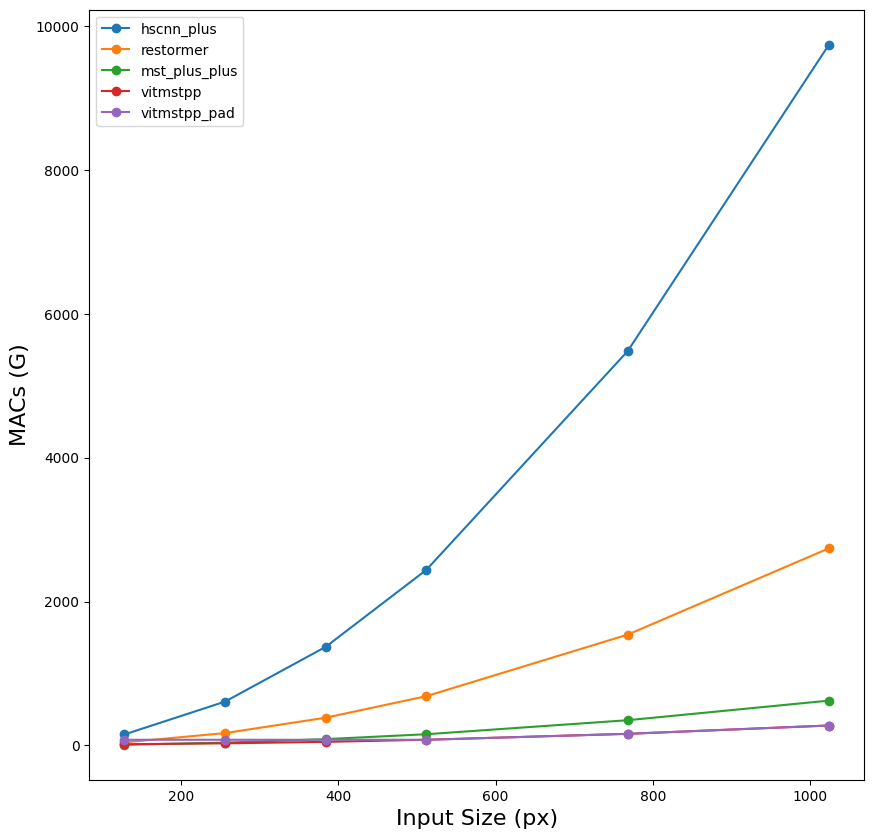

In [27]:
plt.figure(figsize=(10,10))
plt.ylabel('MACs (G)', fontsize=16)
plt.xlabel('Input Size (px)', fontsize=16)
for k in macs_dict: 
    plt.plot(np.array(inputs),np.array(macs_dict[k]), 'o-')
    
plt.legend(list(macs_dict.keys()))
plt.show()

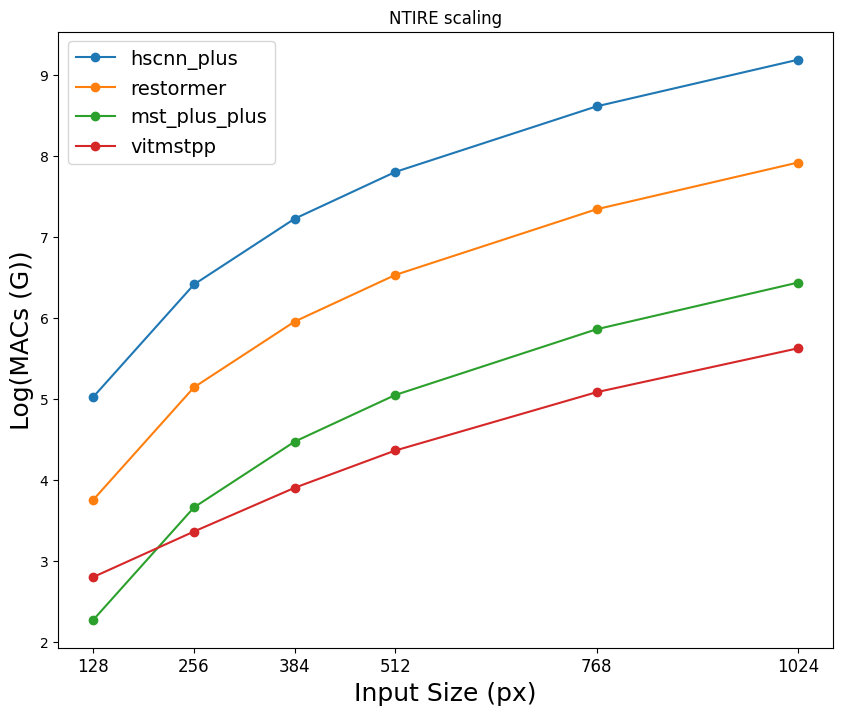

In [5]:
save_path = '/mnt/datassd/mst_toolbox/mst-vitmstpp_ntire/'
plt.figure(figsize=(10,8))
plt.ylabel('Log(MACs (G))', fontsize=18)
plt.xlabel('Input Size (px)', fontsize=18)
for k in macs_dict: 
    if k == 'vitmstpp_pad': 
        continue
    else: 
        plt.plot(np.array(inputs),np.log(np.array(macs_dict[k])), 'o-')
    
plt.legend(list(macs_dict.keys()), fontsize = 14)
plt.xticks(inputs, fontsize=12)
plt.title('NTIRE scaling')
plt.savefig(save_path + 'figure_logmacs_no-pad.png', dpi=800)
plt.show()

In [6]:
models_dict

{'hscnn_plus_128': {'MACs': '(G): 152.22',
  'tot_size': '(MB): 2073.92',
  'trainable': 4645504,
  'n_params': 4645504,
  'gmac': 141.76953125},
 'hscnn_plus_256': {'MACs': '(G): 608.90',
  'tot_size': '(MB): 8239.94',
  'trainable': 4645504,
  'n_params': 4645504,
  'gmac': 567.078125},
 'hscnn_plus_384': {'MACs': '(T): 1.37',
  'tot_size': '(MB): 18516.64',
  'trainable': 4645504},
 'hscnn_plus_512': {'MACs': '(T): 2.44',
  'tot_size': '(MB): 32904.02',
  'trainable': 4645504},
 'hscnn_plus_768': {'MACs': '(T): 5.48',
  'tot_size': '(MB): 74010.82',
  'trainable': 4645504},
 'hscnn_plus_1024': {'MACs': '(T): 9.74',
  'tot_size': '(MB): 131560.34',
  'trainable': 4645504},
 'restormer_128': {'MACs': '(G): 42.80',
  'tot_size': '(MB): 4560.07',
  'trainable': 15108705,
  'n_params': 15108705,
  'gmac': 43.666202545166016},
 'restormer_256': {'MACs': '(G): 171.22',
  'tot_size': '(MB): 18058.98',
  'trainable': 15108705,
  'n_params': 15108705,
  'gmac': 174.66481018066406},
 'restorme

In [ ]:
del model

In [ ]:
md = 'restormer'
model = model_generator(md).cuda()
summary_str = str(torchinfo.summary(model, input_size=(1,3,1024,1024)))
del model


#models_dict[nm]['MACs'] = summary_str.split('Total mult-adds ')[1].split('\n')[0]
#models_dict[nm]['tot_size'] = summary_str.split('Estimated Total Size ')[1].split('\n')[0]
#models_dict[nm]['trainable'] = int(summary_str.split('Trainable params: ')[1].split('\n')[0].replace(',',''))

In [ ]:
del model

In [ ]:
for md in models: 
    print(md)
    model = model_generator(md).cuda()
    print('TORCHINFO')
    print(torchinfo.summary(model, input_size=(2,3,256,256)))
    #print('MY SUMMARY')
    #print(my_summary(model, 256, 256, 3, 2))

In [ ]:
batch_size = 2

In [ ]:
torchinfo.summary(model, input_size=(2,3,256,256)).keys()

In [ ]:
torchinfo.summary(model, input_size=(1,3,256,256))

In [ ]:
my_summary(model, 256, 256, 31, 1)

In [ ]:
torchinfo.summary(model, input)